<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_DocumentSegmentation_YoloV5_PredictionLibrary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict with yoloV5 as library

[YoloV5](https://github.com/ultralytics/yolov5) models use console scripts to predict. The prediction is exposed using files (images and label texts). This is not the best way to integrate a model in a code. Ideally, the model should be executable as library and the results should be accesible as response of the function call.

In this notebook, I present a basic option of use the yolo model predicter as library. 

In [1]:
from IPython.display import clear_output 

## Dataset

We download test images to predict and the `weight` file to load the model.

* Test images

We are going to use images (png) of document pages to test the document segmentation. They are simple pages from a pdf converted to png.

If in some moment this personal dataset is not available, you simply generate your own dataset or look for a public dataset as [this](https://github.com/ibm-aur-nlp/PubLayNet/tree/master/examples) or [this](http://lampsrv02.umiacs.umd.edu/projdb/edit/userfiles/datasets/Page_Segmentation_Dataset.lzh) about page segmentation.

In [2]:
!rm test_images -R

rm: cannot remove 'test_images': No such file or directory


In [3]:
import os

print(" > Download the test dataset ")
!wget https://www.dropbox.com/s/yow9mjgt7cs35c0/validation..doc..pages.tar.gz?dl=0  -O docpages.tar.gz
!tar -zxvf docpages.tar.gz
!rm docpages.tar.gz

clear_output()

 * Weights from a previous training
 
I use a previous trained model from a **NO PUBLIC** dataset. Used notebook available from [link](https://github.com/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_YoloV5_Custom_DataSpartan_Dataset.ipynb).

The result of the trainning process was uploaded to my profesional driver account (this is **not public available**)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!cp /content/drive/My\ Drive/last_yolov5s_results.pt /content/last_yolov5s_results.pt

In [6]:
!ls

drive  last_yolov5s_results.pt	sample_data  validation..doc..pages


## Configure yolov5 to predict directly

We download the yolov5 code to use internally in our code

In [7]:
!rm yolov5/ -R
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies

clear_output()

In [8]:
! ls yolov5

data	    hubconf.py	models		  test.py	  utils
detect.py   inference	README.md	  train.py	  weights
Dockerfile  LICENSE	requirements.txt  tutorial.ipynb


We generate a custom class that we insert in the yolov5 project. This custom class allows predict directly.

```
from models.experimental import *
from utils.datasets import *
from utils.utils import *

# For google colab
from google.colab.patches import cv2_imshow
# No google colab
import cv2

class YoloCustomImagePredicter:

  def __init__(self, weights=None, img_size: int = 640, device: str = ''):

    # Initialize
    self.device = torch_utils.select_device(device)

    self.half = self.device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    self.model = attempt_load(weights, map_location=self.device)  # load FP32 model

    self.img_size = check_img_size(img_size, s=self.model.stride.max())  # check img_size

    if self.half:
      self.model.half()  # to FP16
    
    img = torch.zeros((1, 3, self.img_size, self.img_size), device=self.device)  # init img
    _ = self.model(img.half() if self.half else img) if self.device.type != 'cpu' else None  # run once

    # Get names and colors
    self.names = self.model.module.names if hasattr(self.model, 'module') else self.model.names
    self.colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(self.names))]

    
  def detect(self, source, augment:bool=False, 
            conf_thres:float = 0.4, iou_thres:float = 0.5,
            classes:int=None, agnostic_nms:bool=None,
            view_img=False
            ):

    dataset = LoadImages(source, img_size=self.img_size)

    detections = {}
    # Run inference
    for path, img, im0s, vid_cap in dataset:
      img = torch.from_numpy(img).to(self.device)
      img = img.half() if self.half else img.float()  # uint8 to fp16/32
      img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if img.ndimension() == 3:
        img = img.unsqueeze(0)

      # Inference
      pred = self.model(img, augment=augment)[0]

      # Apply NMS
      pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
      
      for i, det in enumerate(pred):  # detections per image
        im0 = im0s

        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            
            # Write results
            for *xyxy, conf, cls in det:
              xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
              
              pre_img_detections = []
              if path in detections:
                pre_img_detections = detections[path]
              pred_entry = [int(cls), xywh[0], xywh[1], xywh[2], xywh[3]]
              pre_img_detections.append(pred_entry)
              detections[path] = pre_img_detections

              if view_img:

                # Add bbox to image
                label = '%s %.2f' % (self.names[int(cls)], conf)
                plot_one_box(xyxy, im0, label=label, color=self.colors[int(cls)], line_thickness=3)

      if view_img:
        cv2_imshow(im0)

      return detections

```

In [9]:
predicter_filepath = "yolov5/yolo_custom_image_predicter.py"
with open(predicter_filepath, 'w') as f:
    f.write("""
from models.experimental import *
from utils.datasets import *
from utils.utils import *

# For google colab
from google.colab.patches import cv2_imshow
# No google colab
import cv2

class YoloCustomImagePredicter:

  def __init__(self, weights=None, img_size: int = 640, device: str = ''):

    # Initialize
    self.device = torch_utils.select_device(device)

    self.half = self.device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    self.model = attempt_load(weights, map_location=self.device)  # load FP32 model

    self.img_size = check_img_size(img_size, s=self.model.stride.max())  # check img_size

    if self.half:
      self.model.half()  # to FP16
    
    img = torch.zeros((1, 3, self.img_size, self.img_size), device=self.device)  # init img
    _ = self.model(img.half() if self.half else img) if self.device.type != 'cpu' else None  # run once

    # Get names and colors
    self.names = self.model.module.names if hasattr(self.model, 'module') else self.model.names
    self.colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(self.names))]

    
  def detect(self, source, augment:bool=False, 
            conf_thres:float = 0.4, iou_thres:float = 0.5,
            classes:int=None, agnostic_nms:bool=None,
            view_img=False
            ):

    dataset = LoadImages(source, img_size=self.img_size)

    detections = {}
    # Run inference
    for path, img, im0s, vid_cap in dataset:
      img = torch.from_numpy(img).to(self.device)
      img = img.half() if self.half else img.float()  # uint8 to fp16/32
      img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if img.ndimension() == 3:
        img = img.unsqueeze(0)

      # Inference
      pred = self.model(img, augment=augment)[0]

      # Apply NMS
      pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
      
      for i, det in enumerate(pred):  # detections per image
        im0 = im0s

        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            
            # Write results
            for *xyxy, conf, cls in det:
              xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
              
              pre_img_detections = []
              if path in detections:
                pre_img_detections = detections[path]
              pred_entry = [int(cls), xywh[0], xywh[1], xywh[2], xywh[3]]
              pre_img_detections.append(pred_entry)
              detections[path] = pre_img_detections

              if view_img:

                # Add bbox to image
                label = '%s %.2f' % (self.names[int(cls)], conf)
                plot_one_box(xyxy, im0, label=label, color=self.colors[int(cls)], line_thickness=3)

      if view_img:
        cv2_imshow(im0)

      return detections
""")

In [10]:
! ls yolov5

data	    inference  requirements.txt  utils
detect.py   LICENSE    test.py		 weights
Dockerfile  models     train.py		 yolo_custom_image_predicter.py
hubconf.py  README.md  tutorial.ipynb


We include the yolo code as a system path. This is the way to import a script from a notebook. [stackoverflow link](https://stackoverflow.com/questions/4383571/importing-files-from-different-folder)

In [11]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/yolov5')

## Prediction

Define the predictor

In [12]:
from yolov5.yolo_custom_image_predicter import YoloCustomImagePredicter
detecter = YoloCustomImagePredicter(weights="last_yolov5s_results.pt",
                                    img_size=640)

Using CPU

Fusing layers... 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Model Summary: 120 layers, 6.8666e+06 parameters, 6.31725e+06 gradients


Predict the annotations

image 1/1 /content/validation..doc..pages/econreports..001687.png: 

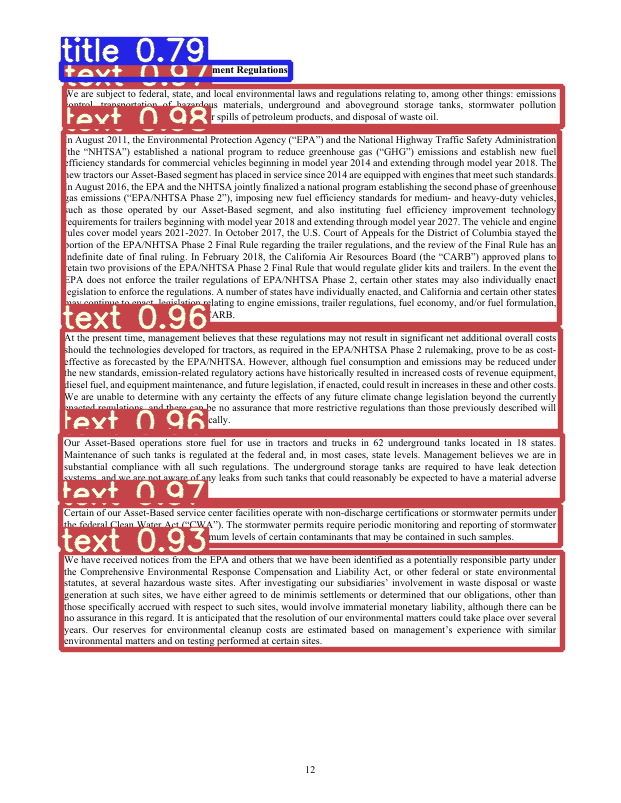

In [13]:
import glob
import random

rnd_img_filepath = random.choice(glob.glob(f'validation..doc..pages/*.png'))

detections = detecter.detect(source=rnd_img_filepath,
                             view_img=True ## Depu
                             )

We review the predictions

In [14]:
print(f"Number of analysed images : {len(detections)}")
for img_detec in detections:
  img_detections = detections[img_detec]

  print(f"\t - {img_detec} : {len(img_detections)}")
  for detect in img_detections:
    print(f"\t\t > [{detect[0]}] - {detect[1:]}")

Number of analysed images : 1
	 - /content/validation..doc..pages/econreports..001687.png : 7
		 > [1] - [0.500805139541626, 0.28331258893013, 0.7987117767333984, 0.2403486967086792]
		 > [1] - [0.499194860458374, 0.6537982821464539, 0.805152952671051, 0.049813199788331985]
		 > [1] - [0.5040257573127747, 0.132004976272583, 0.8019323945045471, 0.049813199788331985]
		 > [1] - [0.500805139541626, 0.5815691351890564, 0.8083735704421997, 0.08219178020954132]
		 > [1] - [0.500805139541626, 0.4732254147529602, 0.8019323945045471, 0.12702366709709167]
		 > [1] - [0.501610279083252, 0.7478206753730774, 0.8067632913589478, 0.12079700827598572]
		 > [2] - [0.28260868787765503, 0.08779576420783997, 0.3687600791454315, 0.021170610561966896]


## Doc Segmenter class

Now we develop a way to use the yoloV5 model as library. Then, we can use this adaptation to generate our own class predicter.

In [15]:
import cv2
import numpy as np
import torch

from yolov5.yolo_custom_image_predicter import YoloCustomImagePredicter


class YoloDocSegmenter:

    def __init__(self, checkpoints_path: str):

        # Load segmentation model
        self.detecter = YoloCustomImagePredicter(
                                                  weights=checkpoints_path,
                                                  img_size=640
                                                 )

    def predict_doc_segments(self, inp_img: str, original_h: int = None,
                             original_w: int = None):
        """
        Prediction the document segments and resize to given dimension

        :param inp_img: input file path
        :param original_h: (optional) height to the resize
        :param original_w: (optional) width to the resize
        :return: List of annotation data entries. Each annotation data entry is
                  a list with format [class, x0, y0, w, h]. 
        """

        if not isinstance(inp_img, str):
            raise Exception("Not valid inp_img. It should be a filepath")
        
        if (original_w is None or original_h is None):
            img = cv2.imread(filename=inp_img)
            original_h = img.shape[0]
            original_w = img.shape[1]
        
        predictions = self.detecter.detect(source=inp_img)

        # Only predicts a file (not a folder)
        img_key = list(predictions.keys())[0]
        predictions = predictions[img_key]

        adapted_predictions = []
        for prediction in predictions:
            bboxes_scaled = self.rescale_bboxes(prediction[1:],
                                                (original_w, original_h))
            adapted_predictions.append([prediction[0], 
                                        bboxes_scaled[0], bboxes_scaled[1],
                                        bboxes_scaled[2], bboxes_scaled[3]])

        return adapted_predictions

    @staticmethod
    def box_cxcywh_to_xyxy(x):
        x_c, y_c, w, h = x
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
            (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return b

    @staticmethod
    def rescale_bboxes(out_bbox, size):
        img_w, img_h = size
        b = YoloDocSegmenter.box_cxcywh_to_xyxy(out_bbox)
        b = [int(a*b) for a,b in zip(b,[img_w, img_h, img_w, img_h])]
        return b


In [41]:

rnd_img_filepath = random.choice(glob.glob(f'validation..doc..pages/*.png'))

segmenter = YoloDocSegmenter(checkpoints_path="last_yolov5s_results.pt")
segmentations = segmenter.predict_doc_segments(inp_img=rnd_img_filepath)

print()
segmentations

Using CPU

Fusing layers... 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Model Summary: 120 layers, 6.8666e+06 parameters, 6.31725e+06 gradients
image 1/1 /content/validation..doc..pages/econreports..001640.png: 


[[1, 205, 251, 371, 403],
 [1, 380, 284, 543, 401],
 [1, 380, 409, 543, 592],
 [1, 38, 622, 202, 748],
 [1, 36, 381, 201, 615],
 [1, 36, 330, 196, 379],
 [1, 204, 403, 378, 745],
 [1, 380, 595, 544, 750],
 [1, 38, 100, 203, 219],
 [1, 382, 101, 542, 191],
 [1, 36, 251, 196, 323],
 [1, 208, 142, 369, 217],
 [1, 382, 250, 536, 277],
 [1, 212, 98, 368, 138],
 [2, 36, 234, 182, 250],
 [2, 45, 82, 273, 98],
 [1, 209, 104, 371, 168]]

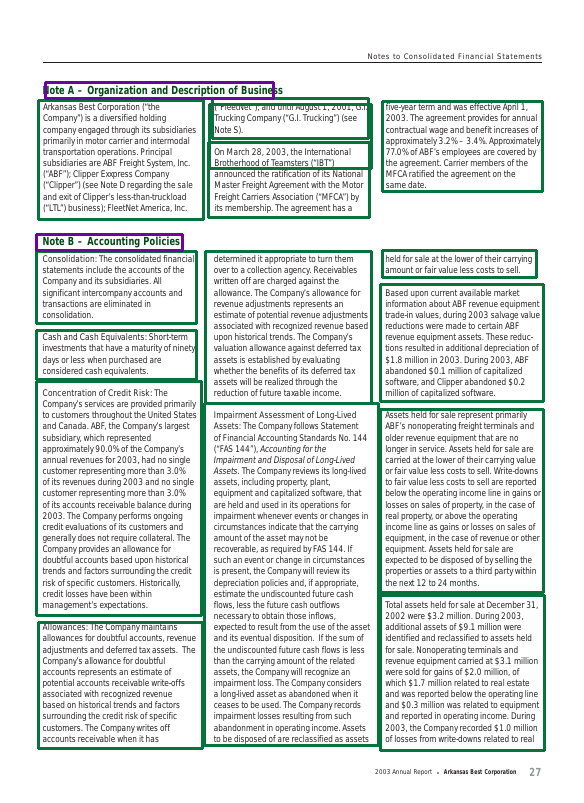

In [42]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(filename=rnd_img_filepath)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(50)]
for segmentation in segmentations:
  cls = segmentation[0]
  x = segmentation[1]
  y = segmentation[2]
  w = segmentation[3] - segmentation[1]
  h = segmentation[4] - segmentation[2]
  cv2.rectangle(img, (x, y), (x + w, y + h), colors[cls], 2)
cv2_imshow(img)